# Human Activity Recognition (HAR) – Exploración de Datos
En este notebook realizamos una exploración inicial del dataset HAR.  
Objetivos principales:
- Cargar los datos de entrenamiento y prueba.  
- Revisar dimensiones y estructura.  
- Analizar la distribución de clases.  
- Visualizar ejemplos de señales crudas.  
## 1. Importar librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

## 2. Cargar los datos

Los archivos están en formato `.h5`.  
- `train.h5` contiene series temporales y etiquetas.  
- `test.h5` contiene solo series temporales.  
- `activity_labels.txt` mapea el índice a la actividad correspondiente.  

In [2]:
# Cargar dataset HAR
train_file = "../data/train.h5"
test_file = "../data/test.h5"
labels_file = "../data/activity_labels.txt"

# Cargar etiquetas de actividades
activity_labels = pd.read_csv(labels_file, sep=" ", header=None, names=["id", "activity"])
print("Etiquetas de actividades:\n", activity_labels.to_string(index=False))

# Leer archivo H5 de entrenamiento
with h5py.File(train_file, "r") as f:
    channels = [
        np.array(f["body_acc_x"]),
        np.array(f["body_acc_y"]),
        np.array(f["body_acc_z"]),
        np.array(f["body_gyro_x"]),
        np.array(f["body_gyro_y"]),
        np.array(f["body_gyro_z"]),
        np.array(f["total_acc_x"]),
        np.array(f["total_acc_y"]),
        np.array(f["total_acc_z"]),
    ]
    y_train = np.array(f["y"]).astype(int)  # etiquetas

# Apilar para formar un único tensor (n_muestras, 128, 9)
X_train = np.stack(channels, axis=-1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Etiquetas de actividades:
  id           activity
  1            WALKING
  2   WALKING_UPSTAIRS
  3 WALKING_DOWNSTAIRS
  4            SITTING
  5           STANDING
  6             LAYING
X_train shape: (7352, 128, 9)
y_train shape: (7352,)


## 3. Chequeos de sanidad

Confirmamos dimensiones, ausencia de NaNs/Infs y revisamos el rango de etiquetas.

In [3]:
n, t, c = X_train.shape
assert t == 128 and c == 9, f"Esperaba (n, 128, 9), obtuve {X_train.shape}"

has_nan = np.isnan(X_train).any()
has_inf = np.isinf(X_train).any()
print(f"NaNs en X_train: {has_nan} | Infs en X_train: {has_inf}")

print("Rango y_train:", y_train.min(), "->", y_train.max())
print("Clases únicas:", np.unique(y_train))

NaNs en X_train: False | Infs en X_train: False
Rango y_train: 1 -> 6
Clases únicas: [1 2 3 4 5 6]


## 4. Mapeo de etiquetas y distribución de clases

El archivo `activity_labels.txt` mapea ID→actividad. Graficamos para ver si las clases están balanceadas.

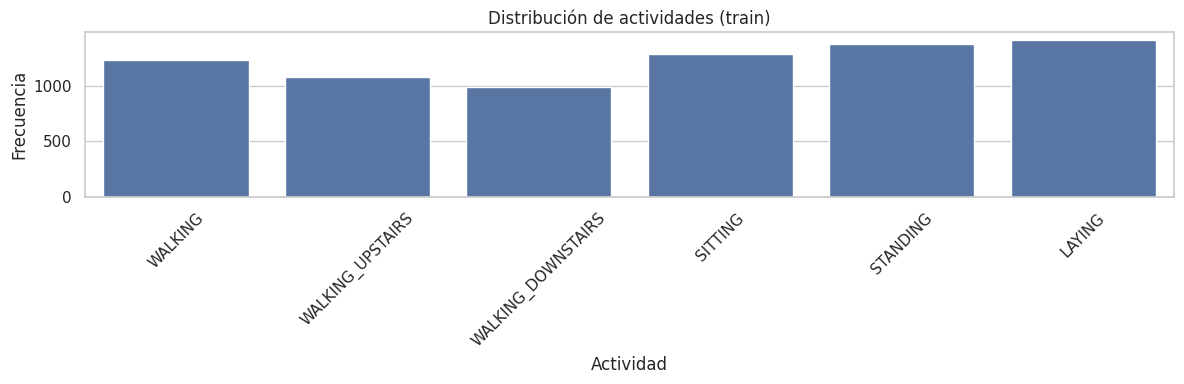

In [4]:
# Mapeo 1..6 (HAR suele venir así)
id_to_name = dict(zip(activity_labels.id, activity_labels.activity))
labels_series = pd.Series([id_to_name[i] for i in y_train], name="activity")

ax = sns.countplot(x=labels_series, order=activity_labels.activity)
ax.set_title("Distribución de actividades (train)")
ax.set_xlabel("Actividad"); ax.set_ylabel("Frecuencia")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## 5. Visualización de ejemplos por actividad

Mostramos una muestra por clase agrupando canales:
- `total_acc_{x,y,z}`
- `body_acc_{x,y,z}`
- `body_gyro_{x,y,z}`

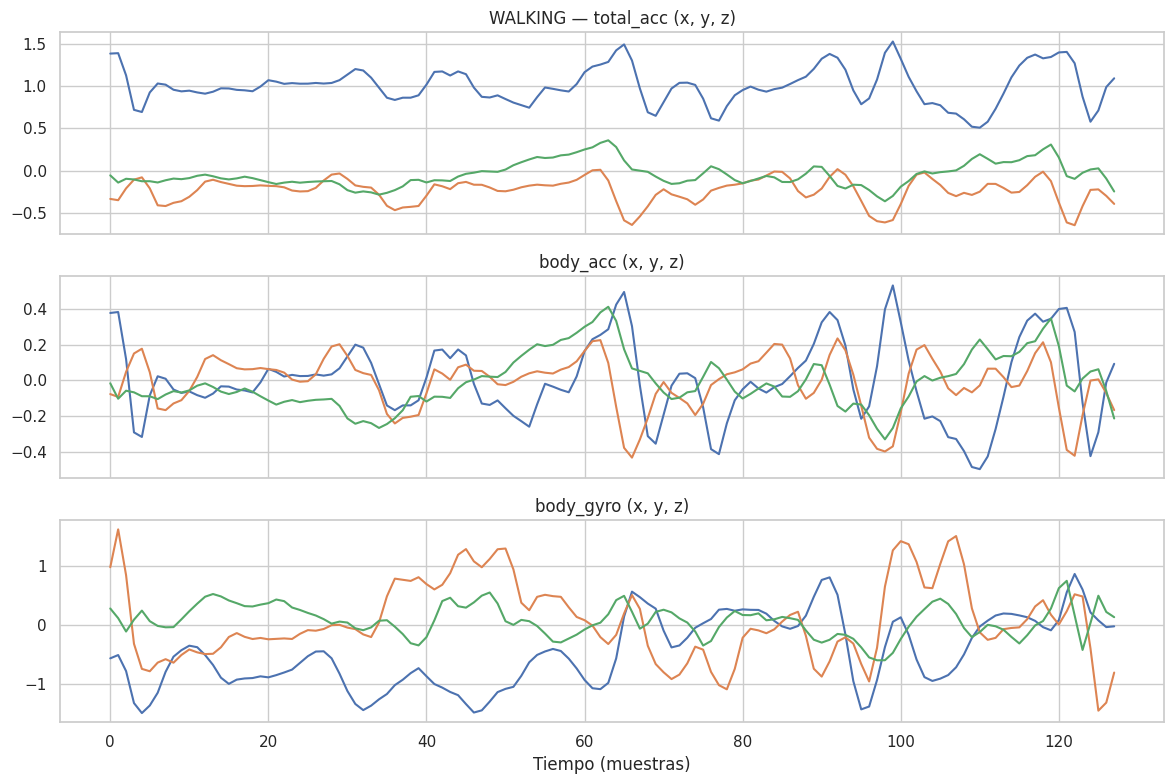

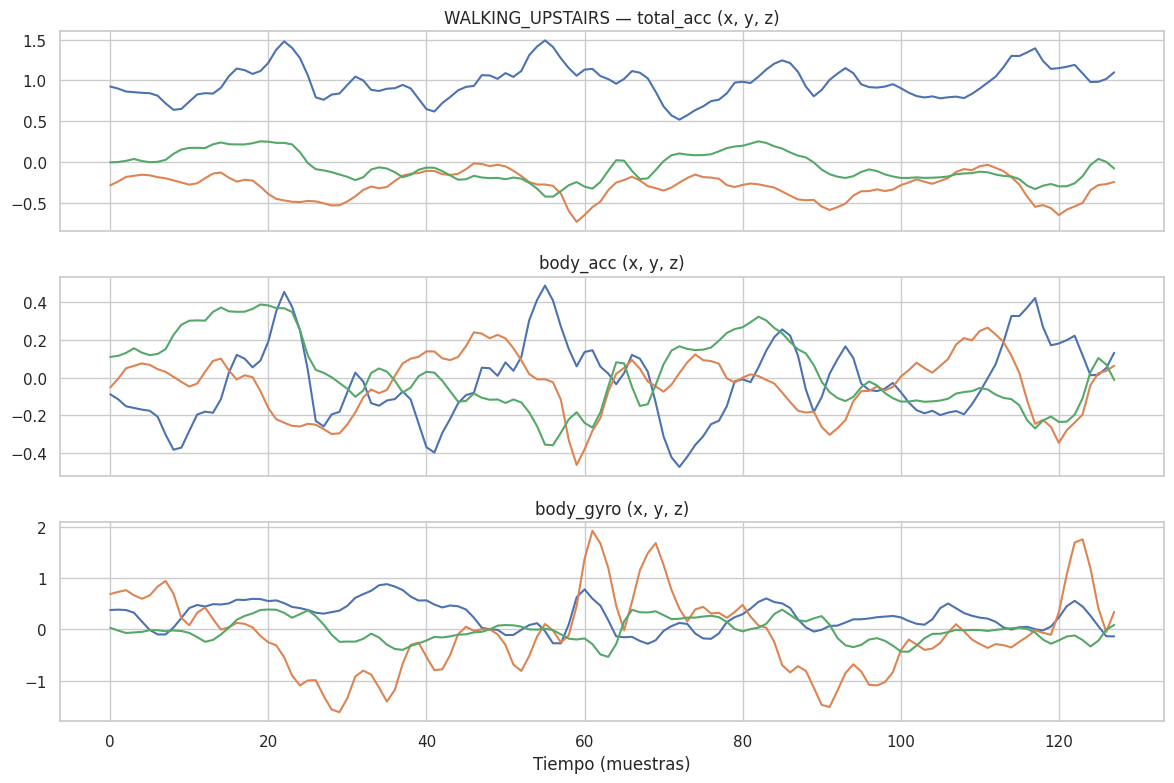

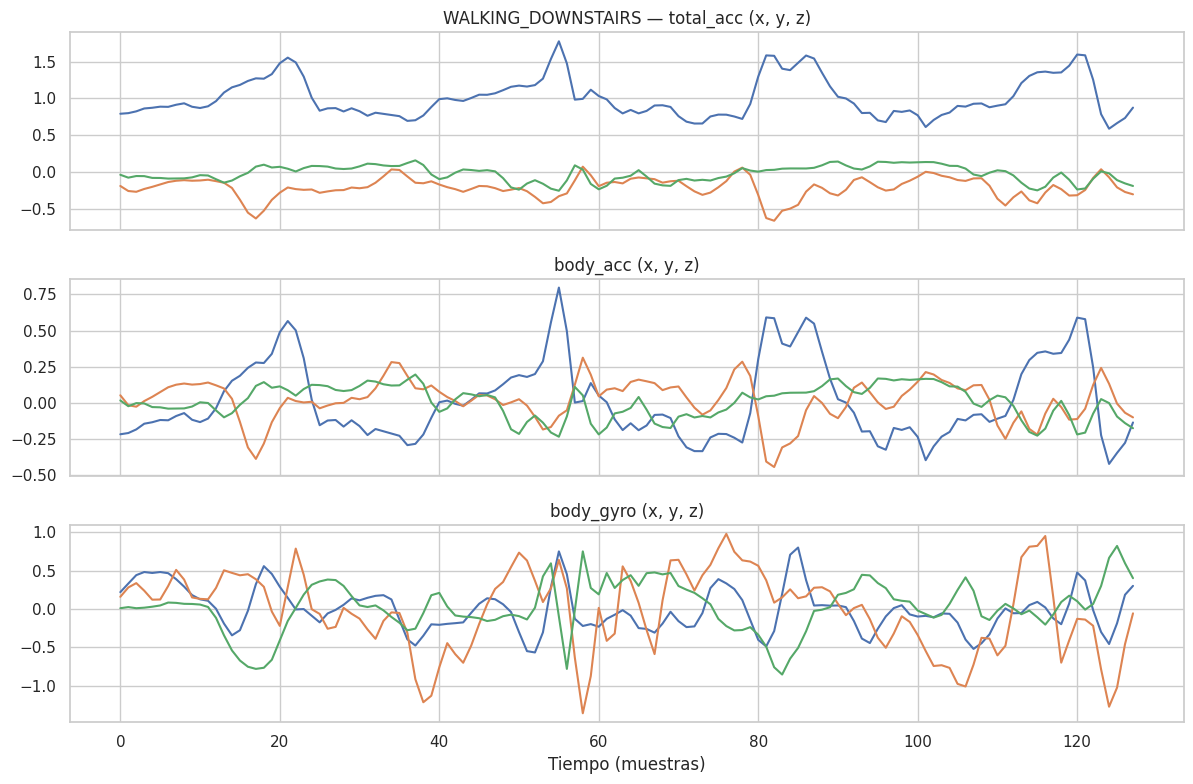

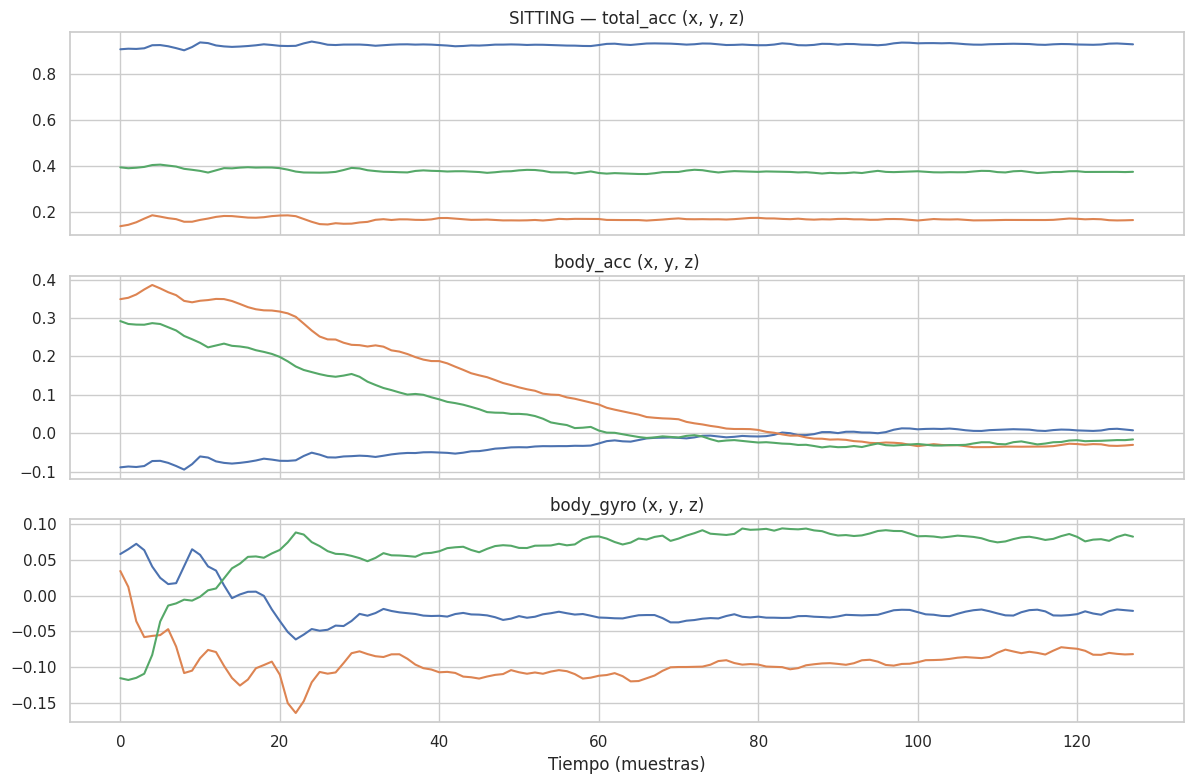

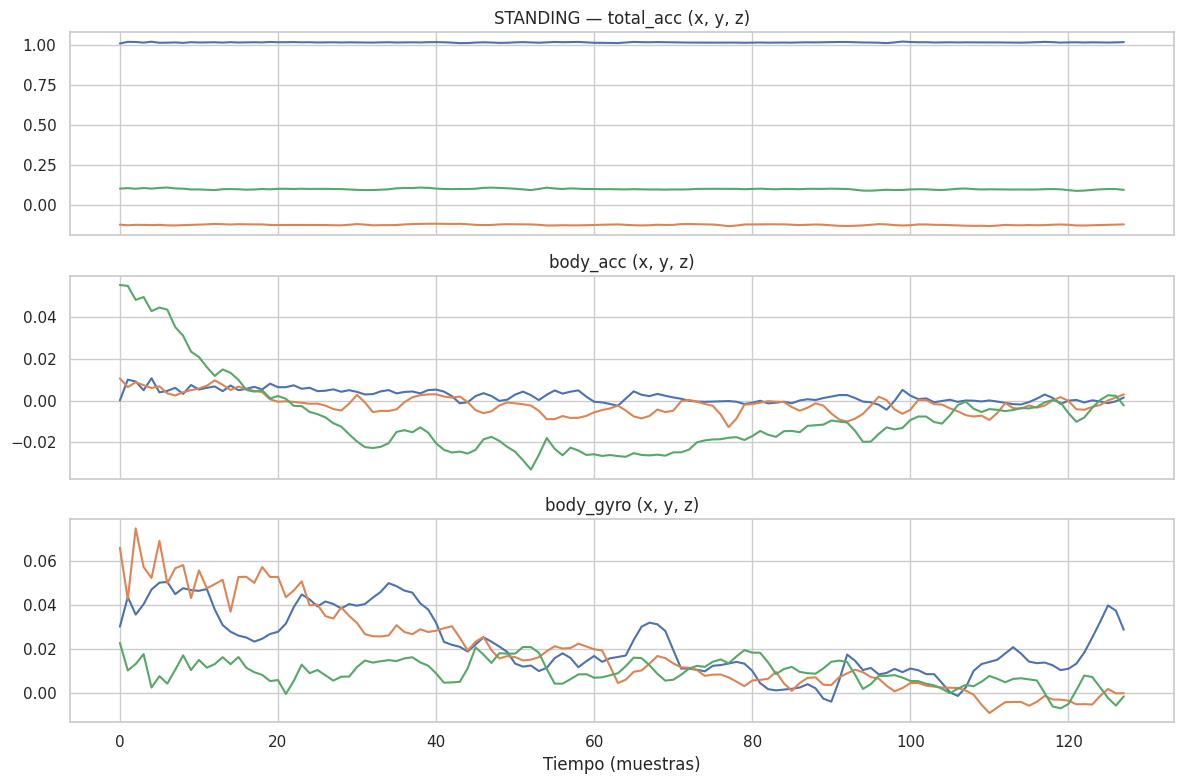

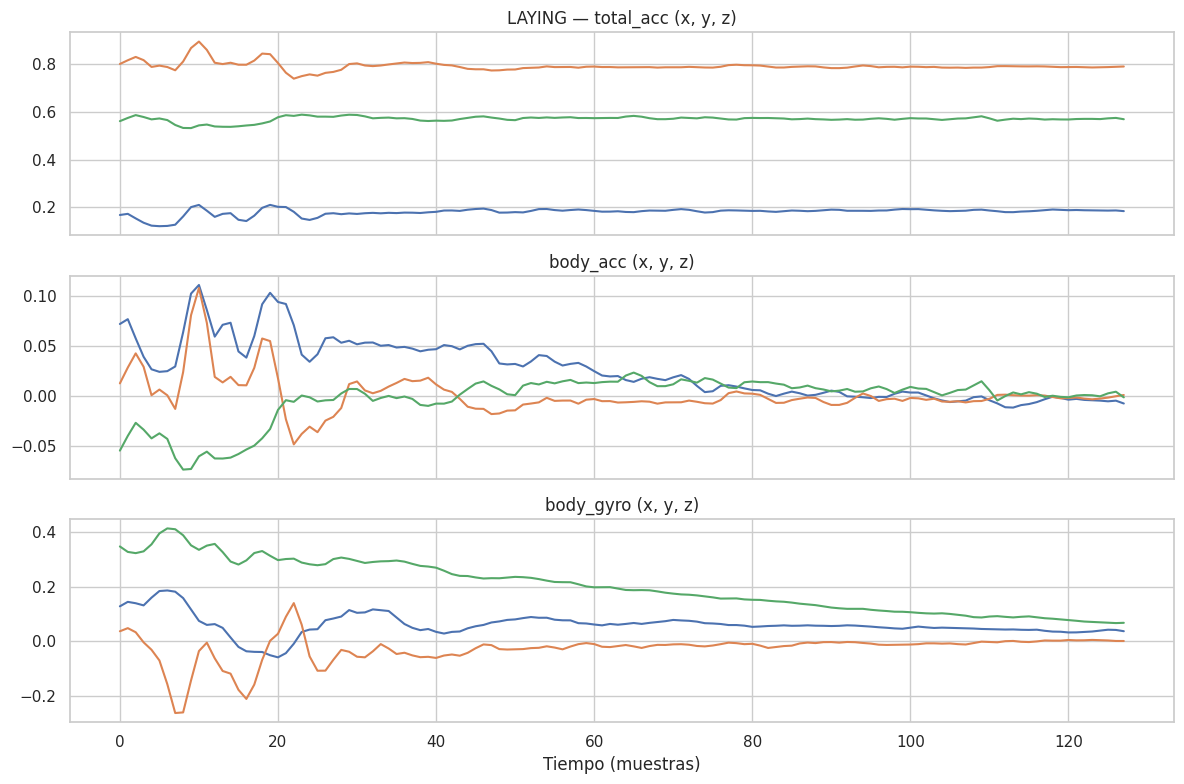

In [5]:
CHANNEL_KEYS = [
    "body_acc_x","body_acc_y","body_acc_z",
    "body_gyro_x","body_gyro_y","body_gyro_z",
    "total_acc_x","total_acc_y","total_acc_z"
]

# Índices de canales por grupo
idx_body_acc  = [CHANNEL_KEYS.index(k) for k in ["body_acc_x","body_acc_y","body_acc_z"]]
idx_body_gyro = [CHANNEL_KEYS.index(k) for k in ["body_gyro_x","body_gyro_y","body_gyro_z"]]
idx_total_acc = [CHANNEL_KEYS.index(k) for k in ["total_acc_x","total_acc_y","total_acc_z"]]

# Un índice por clase (1..6)
sample_indices = [np.where(y_train == cls)[0][0] for cls in sorted(np.unique(y_train))]

for idx, cls in zip(sample_indices, sorted(np.unique(y_train))):
    sig = X_train[idx]  # (128, 9)
    act = id_to_name[cls]

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(sig[:, idx_total_acc[0]]); axes[0].plot(sig[:, idx_total_acc[1]]); axes[0].plot(sig[:, idx_total_acc[2]])
    axes[0].set_title(f"{act} — total_acc (x, y, z)")

    axes[1].plot(sig[:, idx_body_acc[0]]); axes[1].plot(sig[:, idx_body_acc[1]]); axes[1].plot(sig[:, idx_body_acc[2]])
    axes[1].set_title("body_acc (x, y, z)")

    axes[2].plot(sig[:, idx_body_gyro[0]]); axes[2].plot(sig[:, idx_body_gyro[1]]); axes[2].plot(sig[:, idx_body_gyro[2]])
    axes[2].set_title("body_gyro (x, y, z)")
    axes[2].set_xlabel("Tiempo (muestras)")
    plt.tight_layout(); plt.show()

## 6. Cargar `test.h5` y construir `X_test`

Lo armamos con la misma lógica (sin etiquetas).